In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import re

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

In [2]:
%matplotlib inline 

# matplotlib의 한글문제를 해결
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
# font_name
rc('font', family=font_name)

matplotlib.rcParams['axes.unicode_minus'] = False

In [3]:
df = pd.read_csv('data/서울시 지하철 호선별 역별 시간대별 승하차 인원 정보.csv', encoding='utf-8') # csv 파일 읽기
df.head()

,사용월,호선명,지하철역,04시-05시 승차인원,04시-05시 하차인원,05시-06시 승차인원,05시-06시 하차인원,06시-07시 승차인원,06시-07시 하차인원,07시-08시 승차인원,...,23시-24시 하차인원,00시-01시 승차인원,00시-01시 하차인원,01시-02시 승차인원,01시-02시 하차인원,02시-03시 승차인원,02시-03시 하차인원,03시-04시 승차인원,03시-04시 하차인원,작업일자
0,202202,1호선,동대문,649,13,9562,1450,6553,4490,9865,...,5934,18,1028,0,0,0,0,0,0,20220303
1,202202,1호선,동묘앞,105,2,2051,668,2419,3514,4257,...,1713,6,862,0,0,0,0,0,0,20220303
2,202202,1호선,서울역,392,4,6620,4825,8866,28412,28159,...,5067,21,413,0,0,0,0,0,0,20220303
3,202202,1호선,시청,31,0,1418,4040,2260,15348,5038,...,835,3,78,0,0,0,0,0,0,20220303
4,202202,1호선,신설동,199,6,6030,1997,6341,8440,12565,...,3656,14,455,0,0,0,0,0,0,20220303


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50204 entries, 0 to 50203
Data columns (total 52 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   사용월           50204 non-null  int64 
 1   호선명           50204 non-null  object
 2   지하철역          50204 non-null  object
 3   04시-05시 승차인원  50204 non-null  int64 
 4   04시-05시 하차인원  50204 non-null  int64 
 5   05시-06시 승차인원  50204 non-null  int64 
 6   05시-06시 하차인원  50204 non-null  int64 
 7   06시-07시 승차인원  50204 non-null  int64 
 8   06시-07시 하차인원  50204 non-null  int64 
 9   07시-08시 승차인원  50204 non-null  int64 
 10  07시-08시 하차인원  50204 non-null  int64 
 11  08시-09시 승차인원  50204 non-null  int64 
 12  08시-09시 하차인원  50204 non-null  int64 
 13  09시-10시 승차인원  50204 non-null  int64 
 14  09시-10시 하차인원  50204 non-null  int64 
 15  10시-11시 승차인원  50204 non-null  int64 
 16  10시-11시 하차인원  50204 non-null  int64 
 17  11시-12시 승차인원  50204 non-null  int64 
 18  11시-12시 하차인원  50204 non-null  int64 
 19  12시-

In [5]:
df.rename(columns = {'사용월':'사용년월'},inplace=True) # 칼럼 명 변경

## 지하철역 위치 데이터 로드

In [6]:
location_df = pd.read_csv('data/지하철역위치.csv', encoding='utf-8') # csv 파일 읽기
location_df = location_df.rename(columns=location_df.iloc[0])
location_df = location_df.drop(location_df.index[0])

location_df

,철도운영기관명,선명,역명,지번주소,도로명주소
1,코레일,경의중앙,용산,서울특별시 용산구 한강로3가 40-999,서울특별시 용산구 한강대로 23길 55
2,코레일,경의중앙,이촌,서울특별시 용산구 이촌동 17-69,서울특별시 용산구 이촌로 71길 42
3,코레일,경의중앙,서빙고,서울특별시 용산구 서빙고동 241-98,서울특별시 용산구 서빙고로 238
4,코레일,경의중앙,한남,서울특별시 용산구 한남동 399-7,서울특별시 용산구 독서당로 6길 12-13
5,코레일,경의중앙,옥수,서울특별시 성동구 옥수동 168-1,서울특별시 성동구 동호로 21
...,...,...,...,...,...
628,인천교통공사,인천2호선,모래내시장,인천광역시 남동구 구월동 341-6번지,인천광역시 남동구 구월로 255
629,인천교통공사,인천2호선,만수,인천광역시 남동구 만수동 993번지,인천 남동구 구월로 지하 367
630,인천교통공사,인천2호선,남동구청,인천광역시 남동구 만수동 1006번지,인천광역시 남동구 인주대로 889
631,인천교통공사,인천2호선,인천대공원,인천광역시 남동구 장수동 606-9,인천광역시 남동구 수인로 3687


### 서울특별시 지하철역 추출

In [7]:
def check_location(data):     #지하철역이 서울에 속하는지 체크하는 함수
    if data['지번주소'].startswith('서울특별시'):
        return True
    else:
        return False
    

In [8]:
location_df['서울'] = location_df.apply(check_location, axis = 'columns') #apply를 이용해 서울에 위치하는지 확인

In [9]:
seoul_loc_df = location_df[location_df['서울'] == True] #서울에 위치하는 data만 추출

In [10]:
seoul_stations = list(seoul_loc_df['역명'].unique()) # 284 < 291 -> 이름명 통일하면서 같은거 있는것임
len(seoul_stations)

291

In [11]:
pattern = r'\([^)]*\)'         #정규표현식을 이용하여 괄호내용 제거
x = '선정릉(한국과학창의재단)' #test code

text = re.sub(pattern=pattern, repl='', string= x)
text

'선정릉'

In [12]:
for i in range(len(seoul_stations)):  #for문을 돌며 괄호내용 제거  
    seoul_stations[i] = re.sub(pattern=pattern, repl='', string= seoul_stations[i])
seoul_stations.sort()
seoul_stations

['4.19민주묘지',
 '가락시장',
 '가산디지털단지',
 '가양',
 '가오리',
 '가좌',
 '강남',
 '강남구청',
 '강동',
 '강동구청',
 '강변',
 '개롱',
 '개봉',
 '개포동',
 '개화',
 '개화산',
 '거여',
 '건대입구',
 '경복궁',
 '경찰병원',
 '고덕',
 '고려대',
 '고속터미널',
 '공덕',
 '공릉',
 '공항시장',
 '광나루',
 '광운대',
 '광화문',
 '광흥창',
 '교대',
 '구로',
 '구로디지털단지',
 '구룡',
 '구반포',
 '구산',
 '구의',
 '구일',
 '구파발',
 '국회의사당',
 '군자',
 '굽은다리',
 '금천구청',
 '금호',
 '길동',
 '길음',
 '김포공항',
 '까치산',
 '낙성대',
 '남구로',
 '남부터미널',
 '남성',
 '남영',
 '남태령',
 '내방',
 '노들',
 '노량진',
 '노원',
 '녹번',
 '녹사평',
 '녹천',
 '논현',
 '답십리',
 '당고개',
 '당산',
 '대림',
 '대모산입구',
 '대방',
 '대청',
 '대치',
 '대흥',
 '도곡',
 '도봉',
 '도봉산',
 '독립문',
 '독바위',
 '독산',
 '돌곶이',
 '동대문',
 '동대문역사문화공원',
 '동대입구',
 '동묘앞',
 '동작',
 '둔촌동',
 '등촌',
 '디지털미디어시티',
 '뚝섬',
 '뚝섬유원지',
 '마곡',
 '마곡나루',
 '마들',
 '마장',
 '마천',
 '마포',
 '마포구청',
 '망우',
 '망원',
 '매봉',
 '먹골',
 '면목',
 '명동',
 '명일',
 '목동',
 '몽촌토성',
 '무악재',
 '문래',
 '문정',
 '미아',
 '미아사거리',
 '반포',
 '발산',
 '방배',
 '방이',
 '방학',
 '방화',
 '버티고개',
 '보라매',
 '보문',
 '복정',
 '복정',
 '봉은사',
 '봉천',
 '봉화산',
 '북한산보국문',
 '북한산우이',
 '불광',
 '사가정'

In [1]:
seoul_df = pd.read_csv('data/서울시 지하철역 데이터.csv')
seoul_df.drop('Unnamed: 0', axis = 1)

NameError: name 'pd' is not defined

# 4번

In [14]:
seoul_df.rename(columns = {'사용월':'사용년월'},inplace=True) # 칼럼 명 변경

In [15]:
seoul_df = seoul_df[seoul_df['사용년월'] > 201712]
seoul_df.drop('작업일자', axis = 1, inplace = True) # 필요없는 열 삭제
df_before_corona = seoul_df[seoul_df['사용년월'] < 202001] #코로나 이전 데이터 추출
df_after_corona = seoul_df[(seoul_df['사용년월'] >= 202002) & (seoul_df['사용년월'] < 202201)] #코로나 이후 데이터 추출


In [16]:
df_after_corona.loc[:,'총 승차인원'] = df_after_corona.iloc[:, [i for i in range(3,51,2)]].sum(axis=1) #승차인원 데이터만 추출 
df_after_corona.loc[:,'총 하차인원'] = df_after_corona.iloc[:, [i for i in range(4,51,2)]].sum(axis=1) #하차인원 데이터만 추출
df_after_corona.loc[:,'총 유동인원'] = df_after_corona['총 승차인원']+ df_after_corona['총 하차인원']

C:\Users\LEE\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\LEE\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [17]:
df_before_corona.loc[:,'총 승차인원'] = df_before_corona.iloc[:, [i for i in range(3,51,2)]].sum(axis=1) #승차인원 데이터만 추출
df_before_corona.loc[:,'총 하차인원'] = df_before_corona.iloc[:, [i for i in range(4,51,2)]].sum(axis=1) #하차인원 데이터만 추출
df_before_corona.loc[:,'총 유동인원'] = df_before_corona['총 승차인원']+ df_before_corona['총 하차인원']

In [18]:
df_after_corona['사용년월'] = pd.to_datetime(seoul_df['사용년월'],format = '%Y%m') # datetime 형식으로 변경
df_before_corona['사용년월'] = pd.to_datetime(seoul_df['사용년월'],format = '%Y%m')

<ipython-input-18-fbe8469ee1da>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_after_corona['사용년월'] = pd.to_datetime(seoul_df['사용년월'],format = '%Y%m') # datetime 형식으로 변경
<ipython-input-18-fbe8469ee1da>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_before_corona['사용년월'] = pd.to_datetime(seoul_df['사용년월'],format = '%Y%m')


In [19]:
df_after_corona['사용월'] = df_after_corona['사용년월'].dt.month # 년, 월 추출
df_after_corona['사용년'] = df_after_corona['사용년월'].dt.year
df_before_corona['사용월'] = df_before_corona['사용년월'].dt.month
df_before_corona['사용년'] = df_before_corona['사용년월'].dt.year

<ipython-input-19-c4744c23f889>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_after_corona['사용월'] = df_after_corona['사용년월'].dt.month # 년, 월 추출
<ipython-input-19-c4744c23f889>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_after_corona['사용년'] = df_after_corona['사용년월'].dt.year
<ipython-input-19-c4744c23f889>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

In [20]:
covid_before =  (
    df_before_corona
    .groupby(['사용월','사용년'])['총 유동인원']
    .agg(['mean'])
    .reset_index().astype(int) 
)
covid_before

,사용월,사용년,mean
0,1,2018,895853
1,1,2019,920160
2,2,2018,787683
3,2,2019,783061
4,3,2018,977908
5,3,2019,959242
6,4,2018,944685
7,4,2019,962085
8,5,2018,968602
9,5,2019,994608


In [21]:
covid_after =  (
    df_after_corona
    .groupby(['사용월','사용년'])['총 유동인원']
    .agg(['mean','sum'])
    .reset_index().astype(int) 
)
covid_after

,사용월,사용년,mean,sum
0,1,2021,585600,213158645
1,2,2020,704525,257856356
2,2,2021,587922,214591733
3,3,2020,579481,212090396
4,3,2021,736496,268084685
5,4,2020,615361,225222341
6,4,2021,725418,264777579
7,5,2020,679839,248141537
8,5,2021,709920,259120840
9,6,2020,705763,259720889


<AxesSubplot:xlabel='사용월', ylabel='mean'>

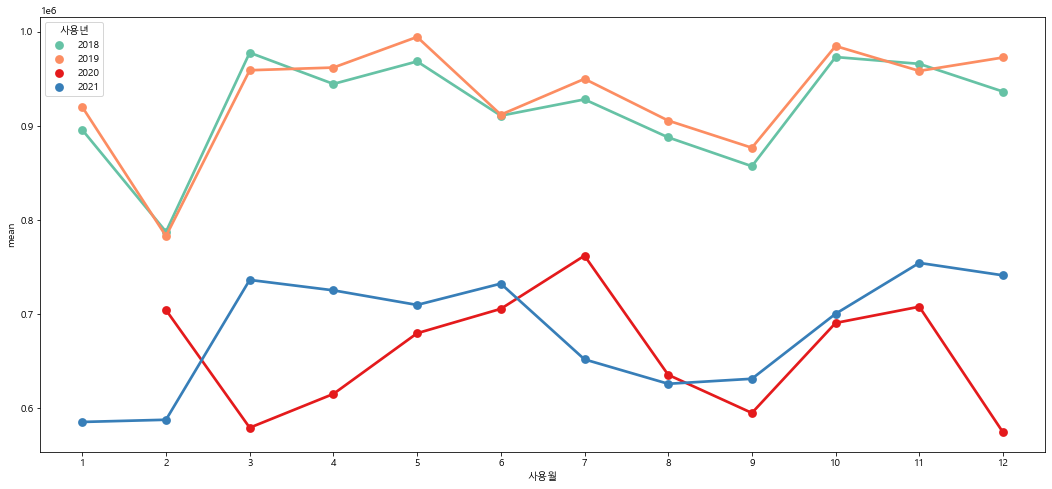

In [22]:
plt.figure(figsize = (18, 8))


sns.pointplot(data=covid_before, x="사용월", y="mean", hue="사용년", palette="Set2")
sns.pointplot(data=covid_after, x="사용월", y="mean", hue="사용년", palette="Set1")

코로나가 유행하기 시작한 2020-02 이후로 지하철 이용량이 급감했음을 그래프를 통해 확인할 수 있다.

# 6번 
월 별 확진자 수 합계 + 지하철 이용 증감률

In [23]:
corona = pd.read_csv('data/서울특별시 코로나19 자치구별 월별 확진자 발생동향(전체 합계)(최종).csv', encoding='utf-8') # csv 파일 읽기
corona.head()

,자치구 기준일,종로구,중구,용산구,성동구,광진구,동대문구,중랑구,성북구,강북구,...,구로구,금천구,영등포구,동작구,관악구,서초구,강남구,송파구,강동구,전체 합계
0,2022년 3월,26955,24391,39948,60090,70714,69378,76716,86479,55322,...,80998,47696,81957,78000,97142,76203,96021,128822,89107,1868123
1,2022년 2월,6310,5548,9872,15423,18404,16835,18563,21192,13579,...,18720,10535,18477,19719,23784,20096,26974,34449,25128,466825
2,2022년 1월,754,768,1424,1433,2017,1842,1780,2069,1110,...,2032,1059,1949,1973,2968,2374,3460,3388,2154,48129
3,2021년 12월,1200,991,1478,1591,2072,3253,2863,3139,2259,...,2878,1891,3059,2590,3271,2489,3323,4252,2919,65000
4,2021년 11월,618,585,630,800,922,1584,1214,1698,1134,...,1935,1137,1932,1381,1732,1048,1218,1947,1519,32202


In [24]:
corona.drop([0,1,2], inplace = True) #이외의 범위 데이터 삭제

In [25]:
corona['자치구 기준일'] = corona['자치구 기준일'].replace("년 ", "-", regex= True).replace('월', '', regex=True) #기준일 데이터 통일화
corona['자치구 기준일'] 

3     2021-12
4     2021-11
5     2021-10
6      2021-9
7      2021-8
8      2021-7
9      2021-6
10     2021-5
11     2021-4
12     2021-3
13     2021-2
14     2021-1
15    2020-12
16    2020-11
17    2020-10
18     2020-9
19     2020-8
20     2020-7
21     2020-6
22     2020-5
23     2020-4
24     2020-3
25     2020-2
Name: 자치구 기준일, dtype: object

In [26]:
corona = corona[::-1] # 데이터 순서 변경
corona = corona.reset_index(drop = True)
corona

,자치구 기준일,종로구,중구,용산구,성동구,광진구,동대문구,중랑구,성북구,강북구,...,구로구,금천구,영등포구,동작구,관악구,서초구,강남구,송파구,강동구,전체 합계
0,2020-2,11,0,0,3,1,1,1,2,0,...,1,1,0,1,3,4,6,12,4,73
1,2020-3,2,4,12,3,4,25,12,13,5,...,32,11,18,22,25,20,32,13,6,351
2,2020-4,3,2,6,13,3,5,3,9,0,...,2,0,5,8,15,14,26,12,3,164
3,2020-5,3,3,20,21,6,3,3,5,9,...,6,3,11,9,16,4,10,11,11,216
4,2020-6,3,3,12,9,3,4,14,4,10,...,45,16,27,13,54,14,9,7,11,427
5,2020-7,6,8,4,8,5,6,11,9,4,...,5,8,9,17,31,7,15,44,14,276
6,2020-8,35,30,46,31,74,73,97,238,78,...,60,33,67,105,100,75,76,158,92,2145
7,2020-9,25,8,22,28,33,32,46,54,38,...,30,19,52,59,139,57,95,80,43,1248
8,2020-10,7,7,21,21,11,27,22,17,15,...,22,7,18,28,90,34,74,54,20,636
9,2020-11,31,42,81,81,39,126,82,107,37,...,69,25,82,124,69,233,158,212,69,2600


In [27]:
covid_after['사용년월'] = covid_after['사용년'].astype(str) + '-' + covid_after['사용월'].astype(str)
covid_after.sort_values(by=['사용년', '사용월'], inplace = True)

temp = []
for i in range(len(covid_after)): # 증감률 계산
    temp.append(((covid_after['mean'][i] - covid_after['mean'][0]) / covid_after['mean'][0]) * 100)

covid_after['증감률'] = temp
covid_after = covid_after.reset_index(drop = True)

In [28]:
covid_after

,사용월,사용년,mean,sum,사용년월,증감률
0,2,2020,704525,257856356,2020-2,0.000000
1,3,2020,579481,212090396,2020-3,20.308231
2,4,2020,615361,225222341,2020-4,0.396516
3,5,2020,679839,248141537,2020-5,-1.044911
4,6,2020,705763,259720889,2020-6,25.767760
5,7,2020,762237,278216610,2020-7,5.082138
6,8,2020,635652,231377339,2020-8,23.876025
7,9,2020,595152,216635433,2020-9,16.092725
8,10,2020,690771,252131617,2020-10,21.229508
9,11,2020,708007,257714667,2020-11,20.519638


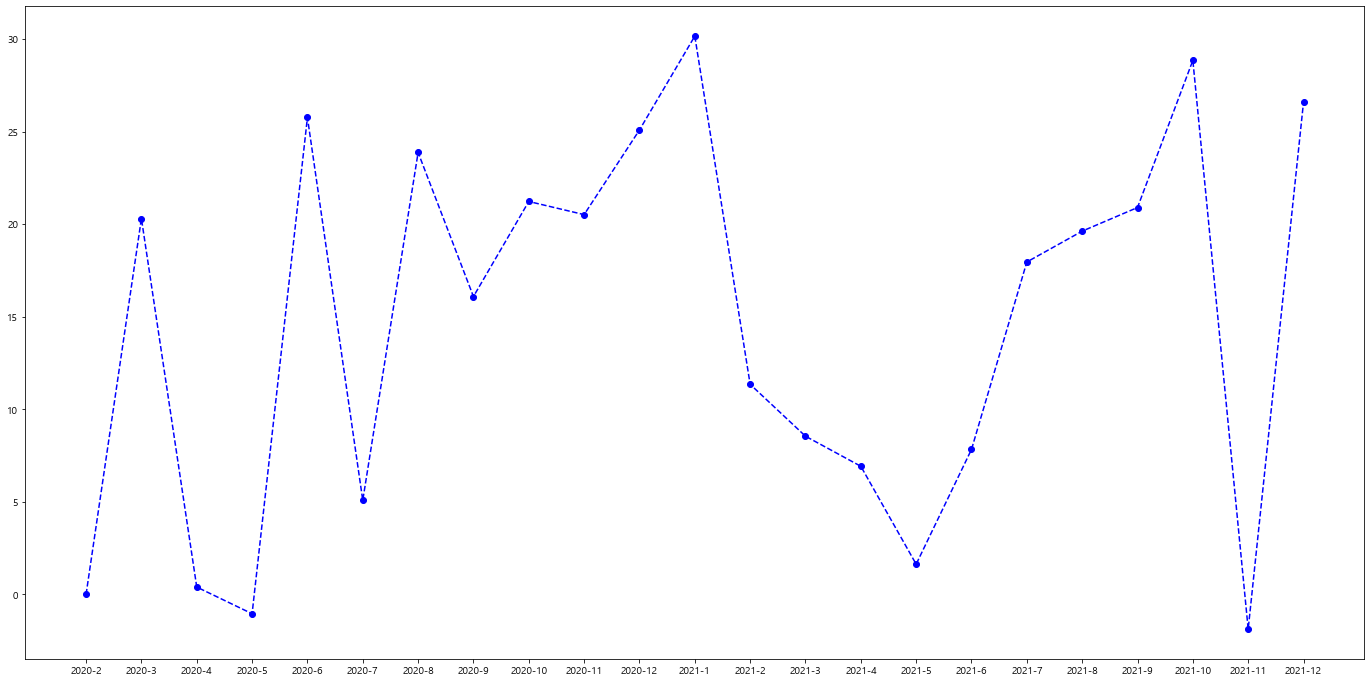

In [29]:
plt.figure(figsize = (24, 12))
plt.plot(covid_after['사용년월'], covid_after['증감률'], color='b',
         linestyle='--', marker='o')

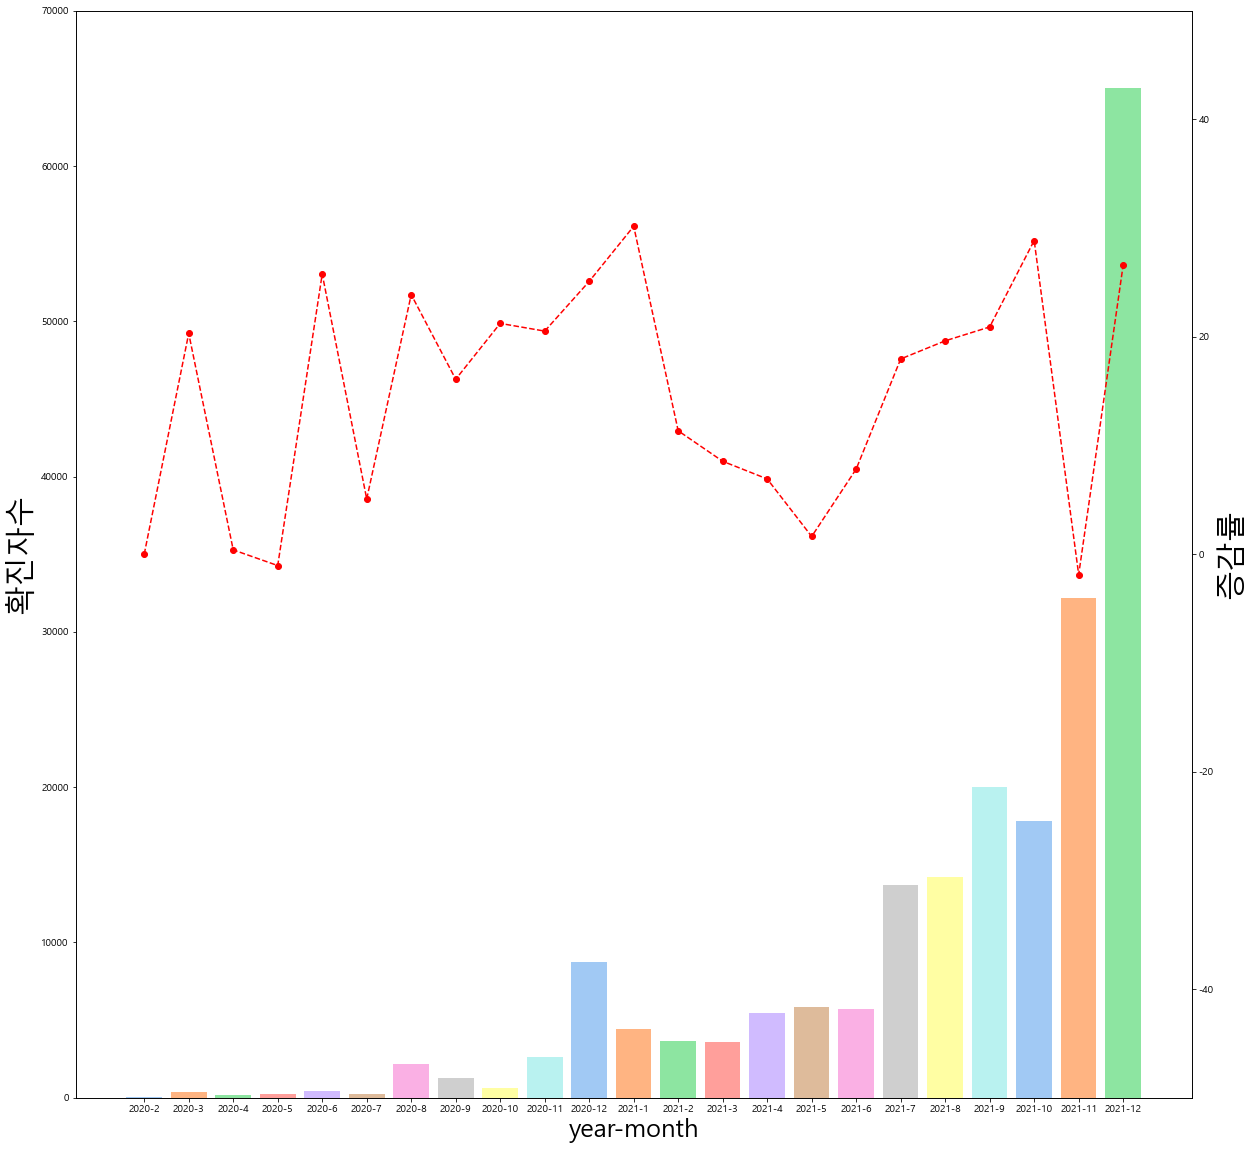

In [30]:

plt.figure(figsize = (20, 20))
colors = sns.color_palette('pastel')


plt.bar(corona['자치구 기준일'], corona['전체 합계'], color=colors)
plt.xlabel('year-month', fontsize=25)
plt.ylim(0,70000)
plt.ylabel('확진자수',fontsize=30)

plt.twinx()

plt.plot(covid_after['사용년월'], covid_after['증감률'], color='r',
         linestyle='--', marker='o')
plt.ylim([-50, 50])
plt.ylabel('증감률', fontsize=30)

plt.show()

코로나가 유행한 후, 코로나가 유행하기 전과 비교해서 지하철 이용량이 급감한 것은 사실이나,
코로나 확진자 수 증가세와 지하철 이용량은 관계가 없음을 확인할 수 있다.

# 코로나 영향 많이 받은 지하철 역 분석

In [31]:
univ_list = ['서울대입구','홍대입구','신촌','이대','한양대','건대입구','교대역','동대입구','성신여대입구','혜화','한성대입구','한대앞','왕십리','고려대','안암','화랑대','공릉','숭실대입구','흑석','서강대','회기', '외대앞', '숙대입구']

In [32]:
univ_df_before = df_before_corona[df_before_corona['지하철역'].isin(univ_list)] #대학가 주변에 위치한 역들만 추출
univ_df_after = df_after_corona[df_after_corona['지하철역'].isin(univ_list)]

In [33]:
univ_mean_df_before = (                           #지하철역 별 총 유동인원을 groupby을 이용해 구한다
    univ_df_before
    .groupby(['지하철역'])['총 유동인원']
    .agg(['mean'])
    .astype(int)
)


univ_mean_df_after= (
    univ_df_after
    .groupby(['지하철역'])['총 유동인원']
    .agg(['mean'])
    .astype(int)
)
univ_mean_df_before, univ_mean_df_after

(           mean
 지하철역           
 건대입구    1930318
 고려대      579155
 공릉       787487
 동대입구     752216
 서강대      137265
 서울대입구   3188599
 성신여대입구   851063
 숙대입구     989981
 숭실대입구    933746
 신촌      1505179
 안암       837316
 왕십리      835225
 외대앞      665174
 이대      1244975
 한성대입구    984709
 한양대      726068
 혜화      2590832
 홍대입구    1744130
 화랑대      697120
 회기      1767234
 흑석       610481,
            mean
 지하철역           
 건대입구    1234874
 고려대      375666
 공릉       587876
 동대입구     390417
 서강대      101766
 서울대입구   2375024
 성신여대입구   577236
 숙대입구     625983
 숭실대입구    596585
 신촌       860912
 안암       490825
 왕십리      574164
 외대앞      373876
 이대       626300
 한성대입구    668821
 한양대      364660
 혜화      1559099
 홍대입구    1081413
 화랑대      494430
 회기      1180239
 흑석       386877)

In [34]:
univ_percentage=pd.merge(univ_mean_df_before, univ_mean_df_after, on = "지하철역")
univ_percentage.rename(columns = {'mean_x':'코로나 이전','mean_y':'코로나 이후'}, inplace = True)

In [35]:

temp = []
for i in range(len(univ_percentage)): # 증감률 계산
    temp.append(((univ_percentage['코로나 이후'][i] - univ_percentage['코로나 이전'][i]) / univ_percentage['코로나 이전'][i]) * 100)


univ_percentage['증감률'] = temp
univ_percentage

,코로나 이전,코로나 이후,증감률
지하철역,,,
건대입구,1930318,1234874,-36.027432
고려대,579155,375666,-35.135499
공릉,787487,587876,-25.347847
동대입구,752216,390417,-48.097754
서강대,137265,101766,-25.861654
서울대입구,3188599,2375024,-25.515124
성신여대입구,851063,577236,-32.174704
숙대입구,989981,625983,-36.768180
숭실대입구,933746,596585,-36.108428


In [36]:
other_df_before = df_before_corona[df_before_corona['지하철역'].isin(univ_list) == False]
other_df_after = df_after_corona[df_after_corona['지하철역'].isin(univ_list) == False]

In [37]:
other_mean_df_before = (
    other_df_before
    .groupby(['지하철역'])['총 유동인원']
    .agg(['mean'])
    .astype(int)
)


other_mean_df_after= (
    other_df_after
    .groupby(['지하철역'])['총 유동인원']
    .agg(['mean'])
    .astype(int)
)
other_mean_df_before, other_mean_df_after

(             mean
 지하철역             
 4.19민주묘지   187829
 가락시장       552397
 가산디지털단지   1710676
 가양        1236165
 가오리        240554
 ...           ...
 홍제        1159966
 화계         189719
 화곡        1747222
 회현        1896785
 효창공원앞      298584
 
 [263 rows x 1 columns],
              mean
 지하철역             
 4.19민주묘지   140650
 가락시장       421193
 가산디지털단지   1493171
 가양         981117
 가오리        199066
 ...           ...
 홍제         846163
 화계         160838
 화곡        1361115
 회현        1154739
 효창공원앞      235228
 
 [263 rows x 1 columns])

In [38]:
other_percentage=pd.merge(other_mean_df_before, other_mean_df_after, on = "지하철역")
other_percentage.rename(columns = {'mean_x':'코로나 이전','mean_y':'코로나 이후'}, inplace = True)
other_percentage

,코로나 이전,코로나 이후
지하철역,,
4.19민주묘지,187829,140650
가락시장,552397,421193
가산디지털단지,1710676,1493171
가양,1236165,981117
가오리,240554,199066
...,...,...
홍제,1159966,846163
화계,189719,160838
화곡,1747222,1361115


In [39]:
temp = []
for i in range(len(other_percentage)): # 증감률 계산
    temp.append(((other_percentage['코로나 이후'][i] - other_percentage['코로나 이전'][i]) / other_percentage['코로나 이전'][i]) * 100)


other_percentage['증감률'] = temp
other_percentage.head()

,코로나 이전,코로나 이후,증감률
지하철역,,,
4.19민주묘지,187829,140650,-25.118060
가락시장,552397,421193,-23.751758
가산디지털단지,1710676,1493171,-12.714564
가양,1236165,981117,-20.632197
가오리,240554,199066,-17.246855


In [40]:
percent = [univ_percentage['증감률'].mean(), other_percentage['증감률'].mean()]
percent

[-36.597959972255794, -23.75333716798085]

<BarContainer object of 2 artists>

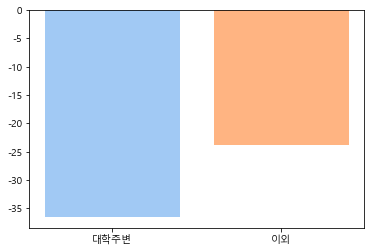

In [41]:
plt.bar(x=["대학주변", "이외"], height= percent, color = colors)

대학가 주변에 위치한 역들이 코로나 영향을 많이 받아 이용 승객 수 감소율이 더 큰 것을 확인할 수 있다.